# Solve the problem leveraging VGG16 architecture
In this notebook, we will use the VGG16 architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on ImageNet we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

## Import Libraries
First of all, let's import all the libraries we will need later.

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics

## Load Dataset from Google Drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/My Drive/Baldi_Cioffo/SplittedDataset.zip" -d "/content"

## Set Parameters

In [4]:
DATASET_PATH = "/content/SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models/vgg16"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [23]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset
The dataset, properly preprocessed, is now located in the local machine.

In [9]:
set_seed()

Below, we report the number of images for each of the two classes (normal vs cancer) in the training set and validation set. 

In [10]:
num_all_tr = len(os.listdir(TRAINING_ALL_PATH))
num_hem_tr = len(os.listdir(TRAINING_HEM_PATH))

num_all_val = len(os.listdir(VALIDATION_PATH + "/all"))
num_hem_val = len(os.listdir(VALIDATION_PATH + "/hem"))

total_train = num_all_tr + num_hem_tr
total_val = num_all_val + num_hem_val

In [11]:
print('total training cancer cell images:', num_all_tr)
print('total training normal cell images:', num_hem_tr)

print('total validation cancer cell images:', num_all_val)
print('total validation normal cell images:', num_hem_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cancer cell images: 3198
total training normal cell images: 3198
total validation cancer cell images: 1403
total validation normal cell images: 729
--
Total training images: 6396
Total validation images: 2132


At this point we need to transform the images we have on disk into preprocessed tensors. 

We decided to use the size that VGG16 expects as input, which is 224x224, and to use batches of size 32.

In [12]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Feature Extraction
This first set of experiments is based on using the architecture of VGG16 simply as a feature extractor.

Let's instantiate the VGG16 model:

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Since we want to perform feature extraction only, we need to "freeze" the convolutional basis.

In [ ]:
conv_base.trainable = False

At this point, we can concatenate a binary classifier to the frozen convolutional basis. 
### Experiment 1: vanilla
This first version is very simple since we connect directly to the convolutional basis a fully connected layer whose 256 neurons feed the output layer containing a single neuron with sigmoidal activation function. 

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vanilla_vgg_model = keras.Model(inputs, outputs)
compile_model(vanilla_vgg_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                             

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 13.1353 - accuracy: 0.7012
Epoch 00001: val_loss improved from inf to 2.94044, saving model to /content/models/vgg16_feature_extraction_vanilla.h5
200/200 [==============================] - 99s 399ms/step - loss: 13.1353 - accuracy: 0.7012 - val_loss: 2.9404 - val_accuracy: 0.6604
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.8462
Epoch 00002: val_loss improved from 2.94044 to 0.57293, saving model to /content/models/vgg16_feature_extraction_vanilla.h5
200/200 [==============================] - 68s 339ms/step - loss: 0.6375 - accuracy: 0.8462 - val_loss: 0.5729 - val_accuracy: 0.7763
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9017
Epoch 00003: val_loss improved from 0.57293 to 0.51475, saving model to /content/models/vgg16_feature_extraction_vanilla.h5
200/200 [==============================] - 66s 327ms/step - loss: 0.241

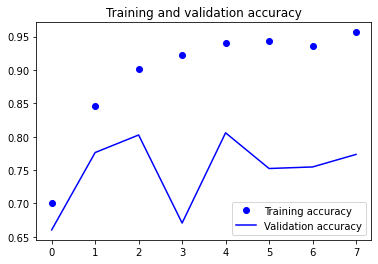

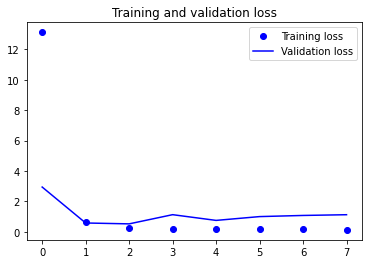

In [ ]:
run_model(vanilla_vgg_model, 'experiment1_feature_extraction_vanilla', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.6671    0.6997    0.6830       696
           1     0.8510    0.8309    0.8408      1437

    accuracy                         0.7881      2133
   macro avg     0.7591    0.7653    0.7619      2133
weighted avg     0.7910    0.7881    0.7893      2133



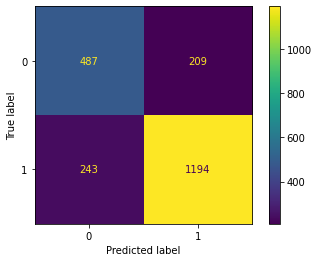

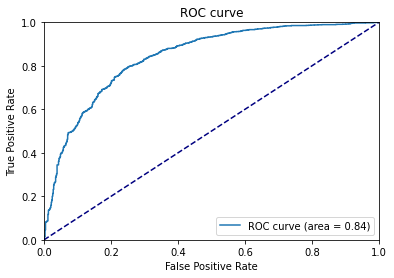

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction_vanilla.h5'))

### Experiment 2: adding dropout
Not surprisingly, the vanilla model performs very poorly and suffers highly from overfitting. We try to solve this problem by adding dropout.

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
dropout_vgg_model = keras.Model(inputs, outputs)
compile_model(dropout_vgg_model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 24.1405 - accuracy: 0.6807
Epoch 00001: val_loss improved from inf to 16.69043, saving model to /content/models/vgg16_feature_extraction_dropout.h5
200/200 [==============================] - 67s 328ms/step - loss: 24.1405 - accuracy: 0.6807 - val_loss: 16.6904 - val_accuracy: 0.6538
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 6.5286 - accuracy: 0.7799
Epoch 00002: val_loss improved from 16.69043 to 6.75495, saving model to /content/models/vgg16_feature_extraction_dropout.h5
200/200 [==============================] - 66s 327ms/step - loss: 6.5286 - accuracy: 0.7799 - val_loss: 6.7550 - val_accuracy: 0.7899
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 2.8992 - accuracy: 0.8247
Epoch 00003: val_loss improved from 6.75495 to 2.58972, saving model to /content/models/vgg16_feature_extraction_dropout.h5
200/200 [==============================] - 65s 326ms/step - loss: 2.

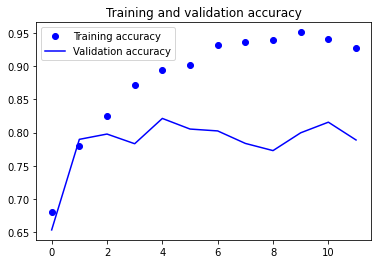

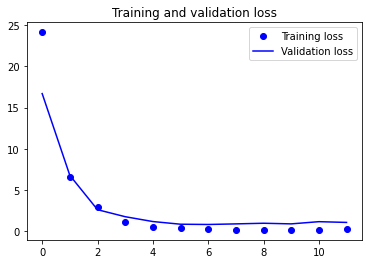

In [ ]:
run_model(dropout_vgg_model, 'experiment2_feature_extraction_dropout', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.6583    0.7141    0.6850       696
           1     0.8556    0.8205    0.8377      1437

    accuracy                         0.7857      2133
   macro avg     0.7569    0.7673    0.7614      2133
weighted avg     0.7912    0.7857    0.7879      2133



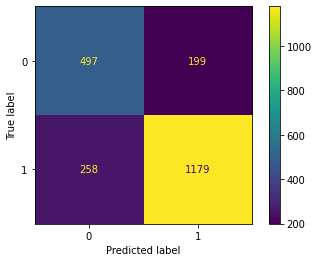

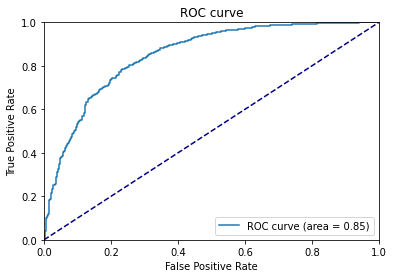

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction_dropout.h5'))

### Experiment 3: global average pooling

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
global_average = keras.Model(inputs, outputs)
compile_model(global_average)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 1.1966 - accuracy: 0.6660
Epoch 00001: val_loss improved from inf to 0.72665, saving model to /content/models/experiment3_feature_extraction_gap.h5
200/200 [==============================] - 102s 414ms/step - loss: 1.1966 - accuracy: 0.6660 - val_loss: 0.7266 - val_accuracy: 0.6778
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.7147
Epoch 00002: val_loss improved from 0.72665 to 0.48830, saving model to /content/models/experiment3_feature_extraction_gap.h5
200/200 [==============================] - 67s 333ms/step - loss: 0.7425 - accuracy: 0.7147 - val_loss: 0.4883 - val_accuracy: 0.7899
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.7258
Epoch 00003: val_loss improved from 0.48830 to 0.46347, saving model to /content/models/experiment3_feature_extraction_gap.h5
200/200 [==============================] - 67s 334ms/step - loss: 

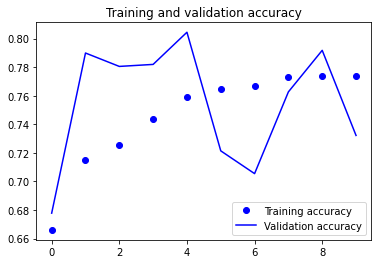

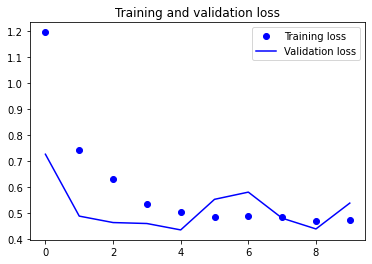

In [ ]:
run_model(global_average, 'experiment3_feature_extraction_gap', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.7443    0.6149    0.6735       696
           1     0.8280    0.8977    0.8614      1437

    accuracy                         0.8054      2133
   macro avg     0.7862    0.7563    0.7675      2133
weighted avg     0.8007    0.8054    0.8001      2133



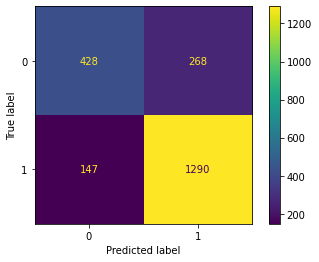

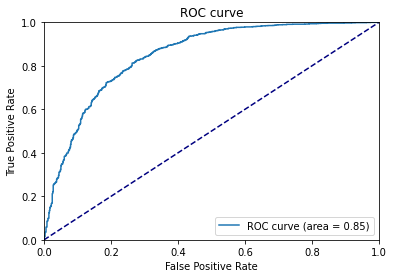

In [13]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction_gap.h5'))

## Fine Tuning
At this point, we try to unfreeze a few layers of the network and re-run the training to increase performance. 

### Experiment 4: last layer

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_11  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0   

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.7988
Epoch 00001: val_loss improved from inf to 0.41769, saving model to /content/models/vgg16_finetuning_1_layer.h5
200/200 [==============================] - 107s 432ms/step - loss: 0.4509 - accuracy: 0.7988 - val_loss: 0.4177 - val_accuracy: 0.8072
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8393
Epoch 00002: val_loss improved from 0.41769 to 0.41245, saving model to /content/models/vgg16_finetuning_1_layer.h5
200/200 [==============================] - 70s 350ms/step - loss: 0.3642 - accuracy: 0.8393 - val_loss: 0.4124 - val_accuracy: 0.8180
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8544
Epoch 00003: val_loss did not improve from 0.41245
200/200 [==============================] - 70s 348ms/step - loss: 0.3392 - accuracy: 0.8544 - val_loss: 0.4338 - val_accuracy: 0.8058
Epoch 4/100
200/200 [======

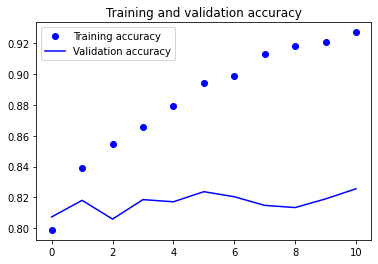

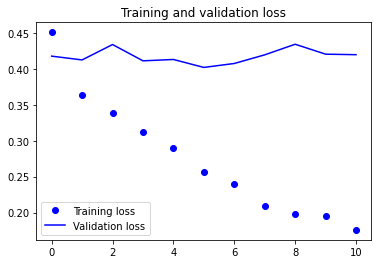

In [ ]:
run_model(vgg_ft_1_layer, 'experiment4_finetuning_1_layer', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.7180    0.7500    0.7337       696
           1     0.8762    0.8573    0.8667      1437

    accuracy                         0.8223      2133
   macro avg     0.7971    0.8037    0.8002      2133
weighted avg     0.8246    0.8223    0.8233      2133



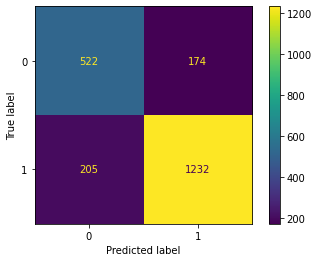

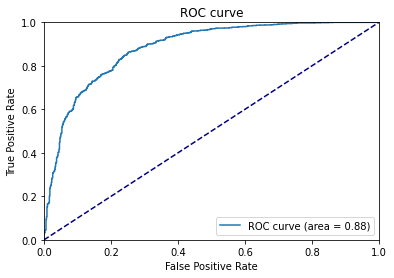

In [14]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_finetuning_1_layer.h5'))

### Experiment 4bis: last layer

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction_gap.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.7953
Epoch 00001: val_loss improved from inf to 0.45953, saving model to /content/models/experiment4bis_finetuning_1_layer.h5
200/200 [==============================] - 100s 403ms/step - loss: 0.4345 - accuracy: 0.7953 - val_loss: 0.4595 - val_accuracy: 0.7735
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8200
Epoch 00002: val_loss improved from 0.45953 to 0.44988, saving model to /content/models/experiment4bis_finetuning_1_layer.h5
200/200 [==============================] - 67s 332ms/step - loss: 0.3910 - accuracy: 0.8200 - val_loss: 0.4499 - val_accuracy: 0.7847
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8396
Epoch 00003: val_loss improved from 0.44988 to 0.42602, saving model to /content/models/experiment4bis_finetuning_1_layer.h5
200/200 [==============================] - 67s 332ms/step - loss: 0.3

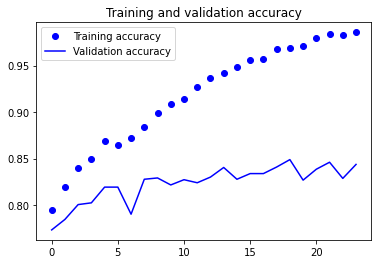

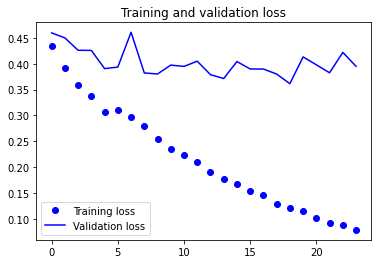

In [ ]:
run_model(vgg_ft_1_layer, 'experiment4bis_finetuning_1_layer', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8013    0.7299    0.7639       696
           1     0.8746    0.9123    0.8931      1437

    accuracy                         0.8528      2133
   macro avg     0.8379    0.8211    0.8285      2133
weighted avg     0.8507    0.8528    0.8509      2133



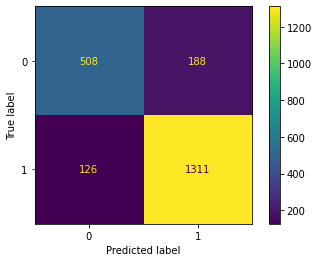

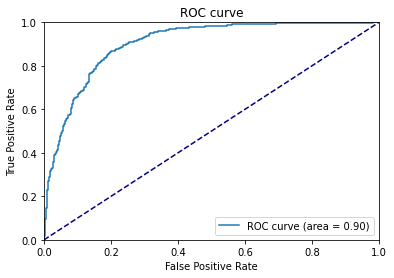

In [15]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4bis_finetuning_1_layer.h5'))

### Experiment 5: last block

In [ ]:
vgg16_ft_1_block = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction_dropout.h5'))

for layer in vgg16_ft_1_block.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_1_block, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_1_block.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_11  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0   

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.8007
Epoch 00001: val_loss improved from inf to 0.42131, saving model to /content/models/vgg16_finetuning_1_block.h5
200/200 [==============================] - 77s 380ms/step - loss: 0.4353 - accuracy: 0.8007 - val_loss: 0.4213 - val_accuracy: 0.8124
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8518
Epoch 00002: val_loss improved from 0.42131 to 0.39413, saving model to /content/models/vgg16_finetuning_1_block.h5
200/200 [==============================] - 75s 376ms/step - loss: 0.3347 - accuracy: 0.8518 - val_loss: 0.3941 - val_accuracy: 0.8302
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8791
Epoch 00003: val_loss did not improve from 0.39413
200/200 [==============================] - 75s 372ms/step - loss: 0.2800 - accuracy: 0.8791 - val_loss: 0.4917 - val_accuracy: 0.7875
Epoch 4/100
200/200 [=======

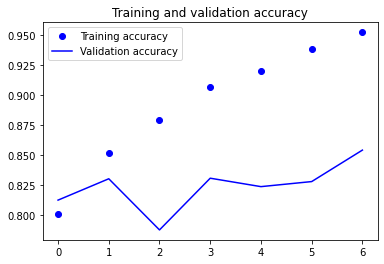

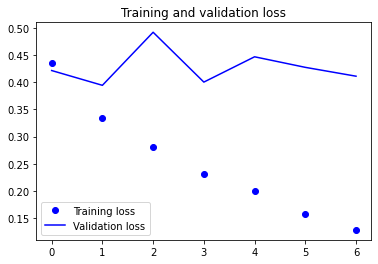

In [ ]:
run_model(vgg16_ft_1_block, 'experiment5_finetuning_1_block', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.7335    0.7198    0.7266       696
           1     0.8655    0.8733    0.8694      1437

    accuracy                         0.8233      2133
   macro avg     0.7995    0.7966    0.7980      2133
weighted avg     0.8224    0.8233    0.8228      2133



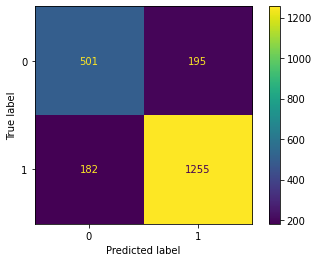

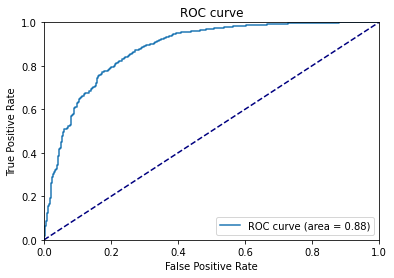

In [16]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment5_finetuning_1_block.h5'))

### Experiment 5bis: last block (Global Average Pooling)

In [ ]:
vgg16_ft_1_block = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction_gap.h5'))

for layer in vgg16_ft_1_block.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_1_block, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_1_block.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.7874
Epoch 00001: val_loss improved from inf to 0.38621, saving model to /content/models/experiment5bis_finetuning_1_block.h5
200/200 [==============================] - 75s 370ms/step - loss: 0.4547 - accuracy: 0.7874 - val_loss: 0.3862 - val_accuracy: 0.8227
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3707 - accuracy: 0.8368
Epoch 00002: val_loss did not improve from 0.38621
200/200 [==============================] - 74s 369ms/step - loss: 0.3707 - accuracy: 0.8368 - val_loss: 0.4353 - val_accuracy: 0.7983
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.8707
Epoch 00003: val_loss did not improve from 0.38621
200/200 [==============================] - 74s 368ms/step - loss: 0.2996 - accuracy: 0.8707 - val_loss: 0.4606 - val_accuracy: 0.7941
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.2494 - accu

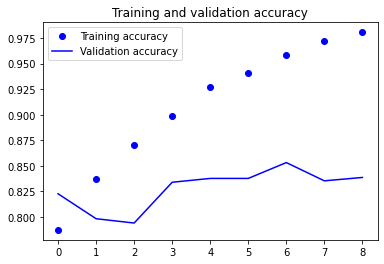

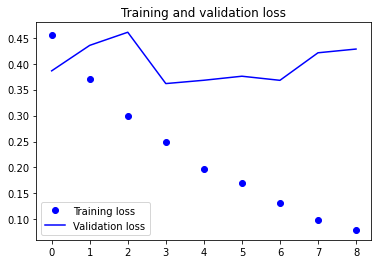

In [ ]:
run_model(vgg16_ft_1_block, 'experiment5bis_finetuning_1_block', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.7824    0.7902    0.7863       696
           1     0.8979    0.8935    0.8957      1437

    accuracy                         0.8598      2133
   macro avg     0.8401    0.8419    0.8410      2133
weighted avg     0.8602    0.8598    0.8600      2133



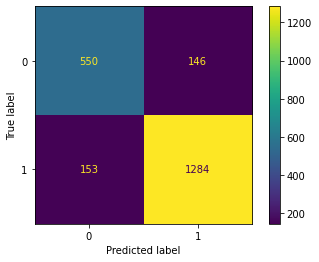

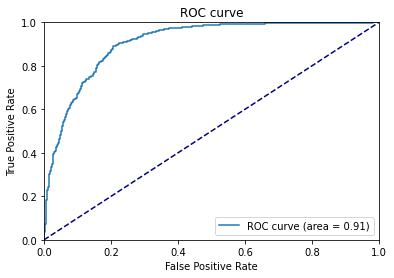

In [17]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment5bis_finetuning_1_block.h5'))

### Experiment 6: two blocks

In [ ]:
vgg16_ft_2_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction_dropout.h5'))

for layer in vgg16_ft_2_blocks.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1', 'block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_2_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_2_blocks.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_11  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0   

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.8069
Epoch 00001: val_loss improved from inf to 0.39503, saving model to /content/models/experiment5_finetuning_2_blocks.h5
200/200 [==============================] - 99s 482ms/step - loss: 0.4378 - accuracy: 0.8069 - val_loss: 0.3950 - val_accuracy: 0.8302
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8505
Epoch 00002: val_loss improved from 0.39503 to 0.38223, saving model to /content/models/experiment5_finetuning_2_blocks.h5
200/200 [==============================] - 96s 481ms/step - loss: 0.3287 - accuracy: 0.8505 - val_loss: 0.3822 - val_accuracy: 0.8321
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.8945
Epoch 00003: val_loss improved from 0.38223 to 0.35695, saving model to /content/models/experiment5_finetuning_2_blocks.h5
200/200 [==============================] - 96s 478ms/step - loss: 0.2461 - a

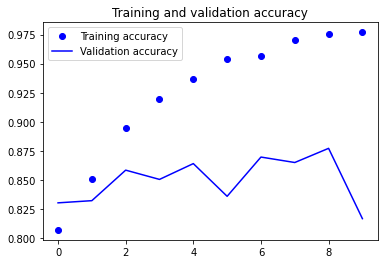

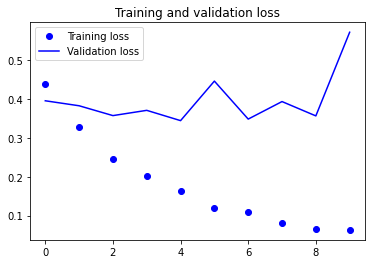

In [ ]:
run_model(vgg16_ft_2_blocks, 'experiment6_finetuning_2_blocks', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8402    0.7026    0.7653       696
           1     0.8665    0.9353    0.8996      1437

    accuracy                         0.8594      2133
   macro avg     0.8534    0.8189    0.8324      2133
weighted avg     0.8579    0.8594    0.8558      2133



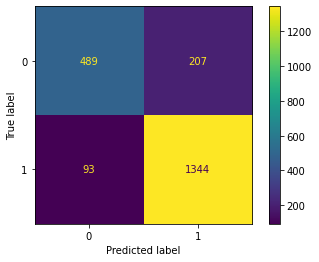

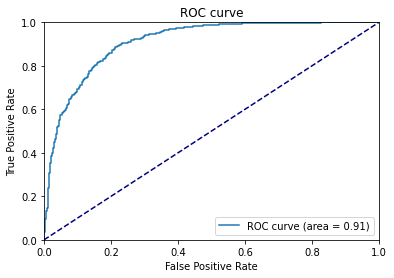

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment6_finetuning_2_blocks.h5'))

### Experiment 6bis: two blocks (Global Average Pooling)

In [ ]:
vgg16_ft_2_blocks_gap = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction_gap.h5'))

for layer in vgg16_ft_2_blocks_gap.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1', 'block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_2_blocks_gap, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_2_blocks_gap.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.7806
Epoch 00001: val_loss improved from inf to 0.36012, saving model to /content/models/experiment6bis_finetuning_2_blocks.h5
200/200 [==============================] - 97s 470ms/step - loss: 0.4570 - accuracy: 0.7806 - val_loss: 0.3601 - val_accuracy: 0.8396
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8571
Epoch 00002: val_loss improved from 0.36012 to 0.34760, saving model to /content/models/experiment6bis_finetuning_2_blocks.h5
200/200 [==============================] - 93s 466ms/step - loss: 0.3297 - accuracy: 0.8571 - val_loss: 0.3476 - val_accuracy: 0.8494
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.8938
Epoch 00003: val_loss did not improve from 0.34760
200/200 [==============================] - 93s 463ms/step - loss: 0.2484 - accuracy: 0.8938 - val_loss: 0.3637 - val_accuracy: 0.8419
Epoch 4/

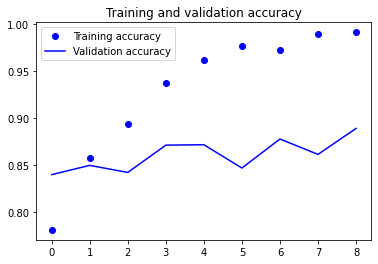

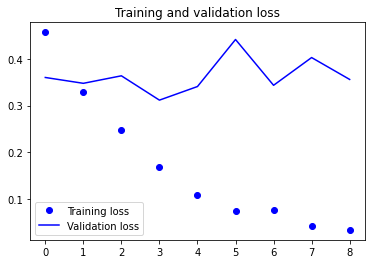

In [ ]:
run_model(vgg16_ft_2_blocks_gap, 'experiment6bis_finetuning_2_blocks', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8129    0.7989    0.8058       696
           1     0.9034    0.9109    0.9071      1437

    accuracy                         0.8744      2133
   macro avg     0.8581    0.8549    0.8565      2133
weighted avg     0.8738    0.8744    0.8741      2133



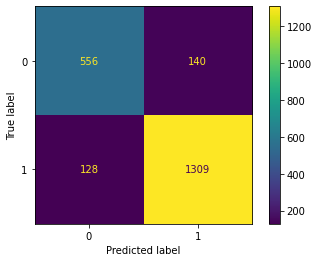

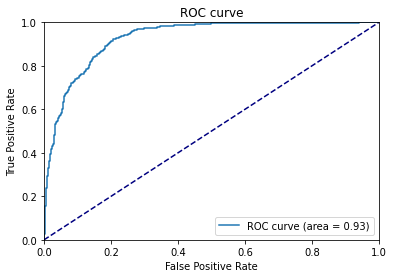

In [18]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment6bis_finetuning_2_blocks.h5'))

## Remove Last Block
Since our dataset is small and very different from ImageNet, we try to remove the last block. In fact, that block should be able to extract features more specific to the images in the original dataset, which therefore may not be suitable for our medical imaging dataset. 

We then repeat the same steps as before, gradually increasing the complexity of the network. 

### Feature Extraction

#### Experiment 7: one FC layer with dropout

In [ ]:
model = Sequential()
for layer in conv_base.layers:
  if layer.name in ("block5_conv1"):
    break
  layer.trainable = False
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 8.5845 - accuracy: 0.6740
Epoch 00001: val_loss improved from inf to 1.62878, saving model to /content/models/vgg16_cut_model_1fc_dropout.h5
200/200 [==============================] - 60s 296ms/step - loss: 8.5845 - accuracy: 0.6740 - val_loss: 1.6288 - val_accuracy: 0.8058
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 3.7705 - accuracy: 0.7247
Epoch 00002: val_loss improved from 1.62878 to 1.42737, saving model to /content/models/vgg16_cut_model_1fc_dropout.h5
200/200 [==============================] - 62s 308ms/step - loss: 3.7705 - accuracy: 0.7247 - val_loss: 1.4274 - val_accuracy: 0.7983
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 2.5711 - accuracy: 0.7442
Epoch 00003: val_loss improved from 1.42737 to 0.99950, saving model to /content/models/vgg16_cut_model_1fc_dropout.h5
200/200 [==============================] - 62s 310ms/step - loss: 2.5711 - accuracy: 0.7

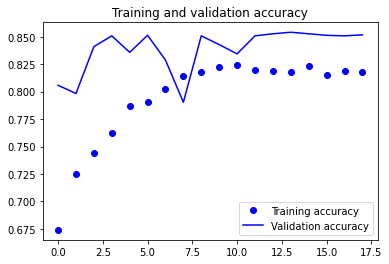

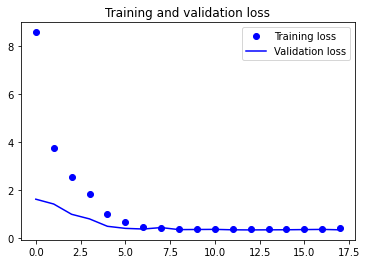

In [ ]:
run_model(vgg_cut_model, 'experiment7_cut_feature_extraction_dropout', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.5576    0.8908    0.6858       696
           1     0.9256    0.6576    0.7689      1437

    accuracy                         0.7337      2133
   macro avg     0.7416    0.7742    0.7274      2133
weighted avg     0.8055    0.7337    0.7418      2133



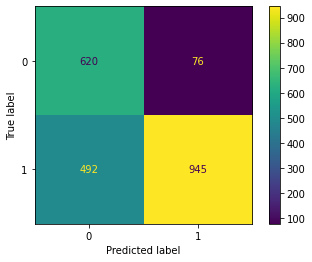

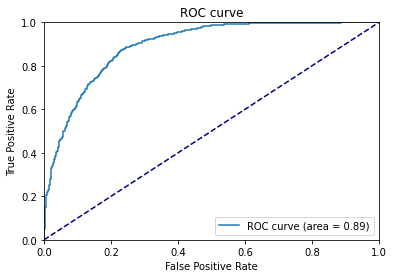

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment7_cut_feature_extraction_dropout.h5'))

#### Experiment 8: RMSprop

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model, optimizer="rmsprop", learning_rate = 5e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 15.1205 - accuracy: 0.5578
Epoch 00001: val_loss improved from inf to 4.46070, saving model to /content/models/vgg16_cut_model_1fc_dropout_rms.h5
200/200 [==============================] - 90s 358ms/step - loss: 15.1205 - accuracy: 0.5578 - val_loss: 4.4607 - val_accuracy: 0.6750
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 8.1422 - accuracy: 0.6417
Epoch 00002: val_loss improved from 4.46070 to 2.67721, saving model to /content/models/vgg16_cut_model_1fc_dropout_rms.h5
200/200 [==============================] - 59s 291ms/step - loss: 8.1422 - accuracy: 0.6417 - val_loss: 2.6772 - val_accuracy: 0.7631
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 5.3617 - accuracy: 0.6718
Epoch 00003: val_loss improved from 2.67721 to 1.92937, saving model to /content/models/vgg16_cut_model_1fc_dropout_rms.h5
200/200 [==============================] - 59s 294ms/step - loss: 5.3617 -

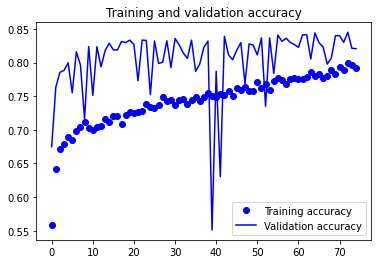

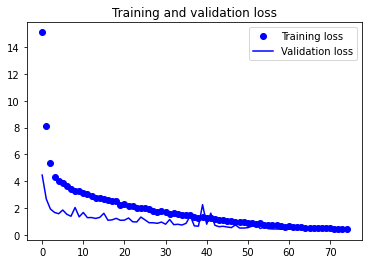

In [ ]:
run_model(vgg_cut_model, 'experiment8_cut_feature_extraction_dropout_rms', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8136    0.7213    0.7647       696
           1     0.8720    0.9200    0.8954      1437

    accuracy                         0.8551      2133
   macro avg     0.8428    0.8206    0.8300      2133
weighted avg     0.8530    0.8551    0.8527      2133



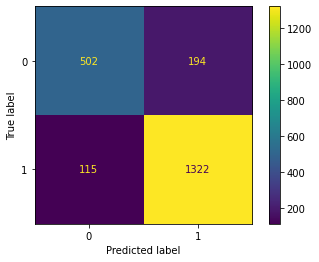

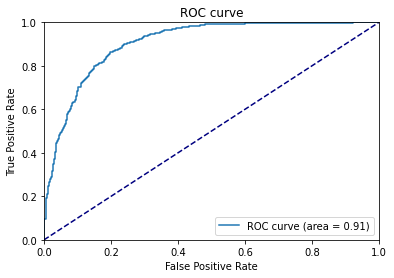

In [19]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment8_cut_feature_extraction_dropout_rms.h5'))

### Fine Tuning

#### Experiment 9: last layer

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer("sequential_2").layers:
    if layer.name in ('block4_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('sequential_2').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.8280
Epoch 00001: val_loss improved from inf to 0.33654, saving model to /content/models/vgg16_cut_ft_1_layer.h5
200/200 [==============================] - 68s 334ms/step - loss: 0.3832 - accuracy: 0.8280 - val_loss: 0.3365 - val_accuracy: 0.8607
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.8468
Epoch 00002: val_loss improved from 0.33654 to 0.33375, saving model to /content/models/vgg16_cut_ft_1_layer.h5
200/200 [==============================] - 66s 331ms/step - loss: 0.3485 - accuracy: 0.8468 - val_loss: 0.3337 - val_accuracy: 0.8579
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8690
Epoch 00003: val_loss improved from 0.33375 to 0.31736, saving model to /content/models/vgg16_cut_ft_1_layer.h5
200/200 [==============================] - 67s 332ms/step - loss: 0.3204 - accuracy: 0.8690 - val_loss: 0.317

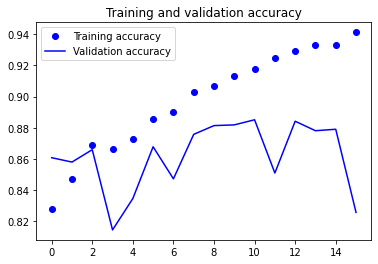

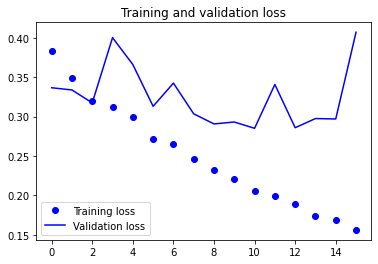

In [ ]:
run_model(vgg_ft_1_layer, 'experiment9_cut_finetuning_1_layer', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8282    0.8175    0.8228       696
           1     0.9122    0.9179    0.9150      1437

    accuracy                         0.8851      2133
   macro avg     0.8702    0.8677    0.8689      2133
weighted avg     0.8848    0.8851    0.8849      2133



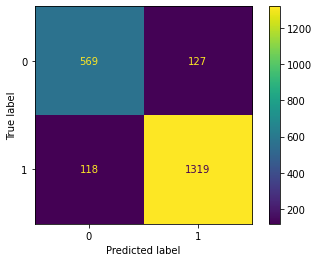

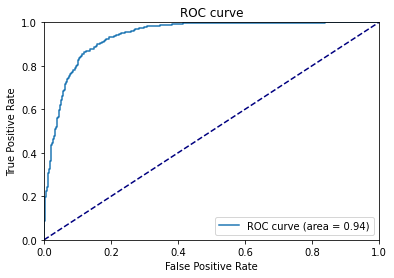

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment9_cut_finetuning_1_layer.h5'))

#### Experiment 9bis: last layer

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment8_cut_feature_extraction_dropout_rms.h5'))

for layer in vgg_ft_1_layer.get_layer("sequential").layers:
    if layer.name in ('block4_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.7888
Epoch 00001: val_loss improved from inf to 0.39241, saving model to /content/models/vgg16_cut_ft_1_layer_rms.h5
200/200 [==============================] - 101s 407ms/step - loss: 0.5035 - accuracy: 0.7888 - val_loss: 0.3924 - val_accuracy: 0.8260
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.8044
Epoch 00002: val_loss improved from 0.39241 to 0.35239, saving model to /content/models/vgg16_cut_ft_1_layer_rms.h5
200/200 [==============================] - 66s 328ms/step - loss: 0.4553 - accuracy: 0.8044 - val_loss: 0.3524 - val_accuracy: 0.8523
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.8158
Epoch 00003: val_loss improved from 0.35239 to 0.33752, saving model to /content/models/vgg16_cut_ft_1_layer_rms.h5
200/200 [==============================] - 66s 327ms/step - loss: 0.4358 - accuracy: 0.8158 - va

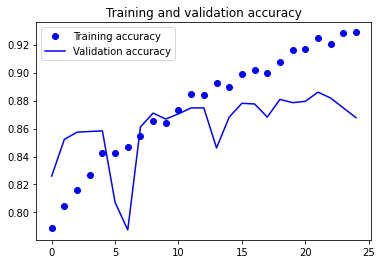

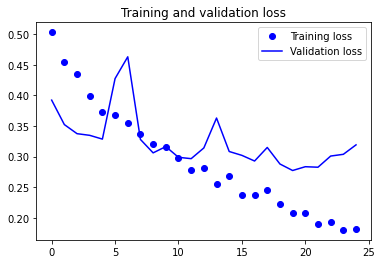

In [ ]:
run_model(vgg_ft_1_layer, 'experiment9bis_cut_finetuning_1_layer', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8611    0.8103    0.8349       696
           1     0.9107    0.9367    0.9235      1437

    accuracy                         0.8955      2133
   macro avg     0.8859    0.8735    0.8792      2133
weighted avg     0.8945    0.8955    0.8946      2133



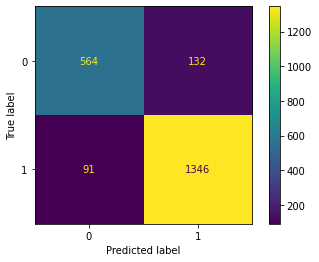

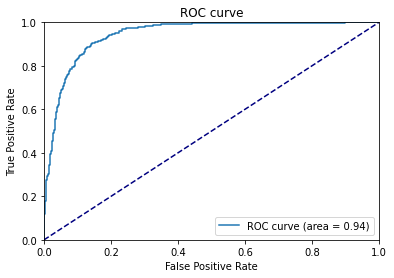

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment9bis_cut_finetuning_1_layer.h5'))

#### Experiment 10: last block

In [ ]:
vgg_ft_1_block = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_1_block.get_layer("sequential_2").layers:
    if layer.name in ('block4_conv3', 'block4_conv1', 'block4_conv2'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_block, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_block.get_layer('sequential_2').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8224
Epoch 00001: val_loss improved from inf to 0.32621, saving model to /content/models/vgg16_cut_ft_1_block.h5
200/200 [==============================] - 83s 405ms/step - loss: 0.4063 - accuracy: 0.8224 - val_loss: 0.3262 - val_accuracy: 0.8607
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.8557
Epoch 00002: val_loss did not improve from 0.32621
200/200 [==============================] - 80s 401ms/step - loss: 0.3330 - accuracy: 0.8557 - val_loss: 0.3563 - val_accuracy: 0.8368
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.8796
Epoch 00003: val_loss did not improve from 0.32621
200/200 [==============================] - 80s 399ms/step - loss: 0.2937 - accuracy: 0.8796 - val_loss: 0.4851 - val_accuracy: 0.7753
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.8949


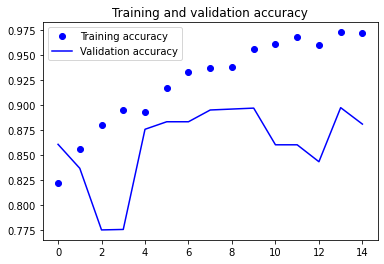

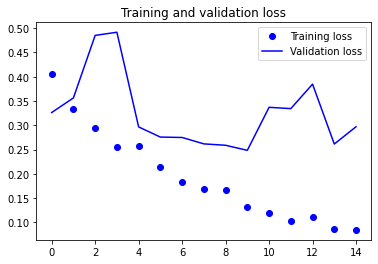

In [ ]:
run_model(vgg_ft_1_block, 'eperiment10_cut_ft_1_block', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8722    0.8333    0.8523       696
           1     0.9210    0.9408    0.9308      1437

    accuracy                         0.9058      2133
   macro avg     0.8966    0.8871    0.8916      2133
weighted avg     0.9051    0.9058    0.9052      2133



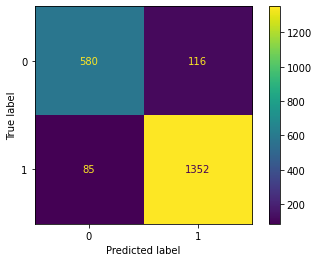

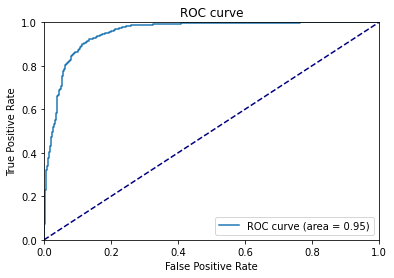

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment10_cut_ft_1_block.h5'))

#### Experiment 10bis: last block

In [ ]:
vgg_ft_1_block = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment8_cut_feature_extraction_dropout_rms.h5'))

for layer in vgg_ft_1_block.get_layer("sequential").layers:
    if layer.name in ('block4_conv3', 'block4_conv1', 'block4_conv2'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_block, optimizer="rms", learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_block.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9123
Epoch 00001: val_loss improved from inf to 0.28998, saving model to /content/models/vgg16_cut_ft_1_block_rms.h5
200/200 [==============================] - 66s 328ms/step - loss: 0.2123 - accuracy: 0.9123 - val_loss: 0.2900 - val_accuracy: 0.8795
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9204
Epoch 00002: val_loss improved from 0.28998 to 0.27498, saving model to /content/models/vgg16_cut_ft_1_block_rms.h5
200/200 [==============================] - 66s 327ms/step - loss: 0.2020 - accuracy: 0.9204 - val_loss: 0.2750 - val_accuracy: 0.8851
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9209
Epoch 00003: val_loss did not improve from 0.27498
200/200 [==============================] - 65s 326ms/step - loss: 0.1942 - accuracy: 0.9209 - val_loss: 0.2826 - val_accuracy: 0.8879
Epoch 4/100
200/200 [=======

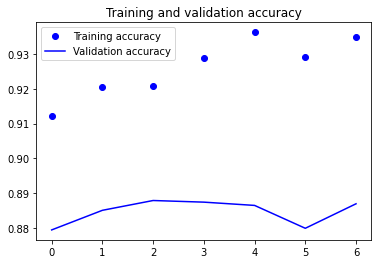

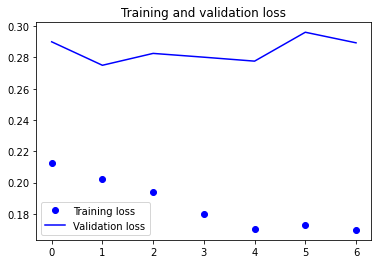

In [ ]:
run_model(vgg_ft_1_block, 'eperiment10bis_cut_ft_1_block', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8722    0.8333    0.8523       696
           1     0.9210    0.9408    0.9308      1437

    accuracy                         0.9058      2133
   macro avg     0.8966    0.8871    0.8916      2133
weighted avg     0.9051    0.9058    0.9052      2133



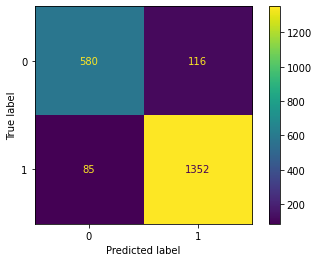

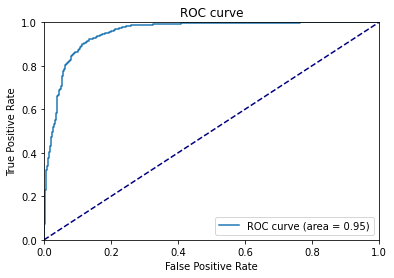

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment10bis_cut_ft_1_block.h5'))

#### Experiment 11: last two blocks

In [ ]:
vgg_ft_2_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_2_blocks.get_layer("sequential_2").layers:
    if layer.name in ('block4_conv3', 'block4_conv1', 'block4_conv2', 'block3_conv3' , 'block3_conv2' , 'block3_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_2_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_2_blocks.get_layer('sequential_2').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9479
Epoch 00001: val_loss improved from inf to 0.25550, saving model to /content/models/vgg16_cut_ft_2_blocks.h5
200/200 [==============================] - 126s 630ms/step - loss: 0.1359 - accuracy: 0.9479 - val_loss: 0.2555 - val_accuracy: 0.9006
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9637
Epoch 00002: val_loss did not improve from 0.25550
200/200 [==============================] - 109s 542ms/step - loss: 0.1040 - accuracy: 0.9637 - val_loss: 0.2608 - val_accuracy: 0.8977
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9531
Epoch 00003: val_loss did not improve from 0.25550
200/200 [==============================] - 108s 541ms/step - loss: 0.1194 - accuracy: 0.9531 - val_loss: 0.3030 - val_accuracy: 0.8823
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9

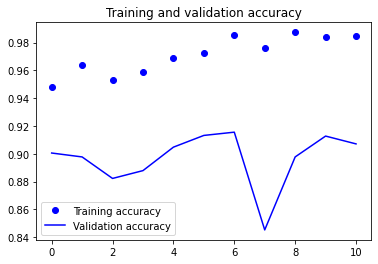

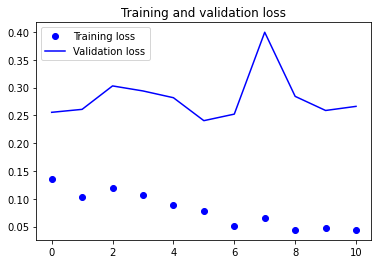

In [ ]:
run_model(vgg_ft_2_blocks, 'eperiment11_cut_ft_2_blocks', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8522    0.8779    0.8648       696
           1     0.9400    0.9262    0.9331      1437

    accuracy                         0.9105      2133
   macro avg     0.8961    0.9021    0.8989      2133
weighted avg     0.9113    0.9105    0.9108      2133



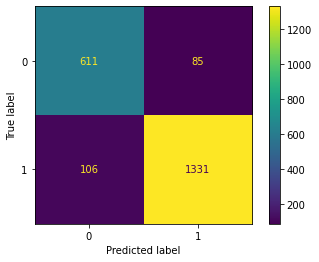

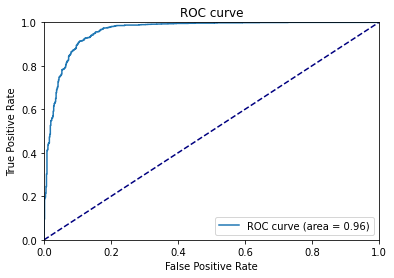

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment11_cut_ft_2_blocks.h5'))

#### Experiment 12: last three blocks

In [ ]:
vgg_ft_3_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_3_blocks.get_layer("sequential_2").layers:
    if layer.name in ('block1_conv2', 'block1_conv1'):
        layer.trainable = False
    else:
        layer.trainable = True

compile_model(vgg_ft_3_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_3_blocks.get_layer('sequential_2').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.8089
Epoch 00001: val_loss improved from inf to 0.39392, saving model to /content/models/vgg16_cut_ft_3_blocks.h5
200/200 [==============================] - 138s 680ms/step - loss: 0.4454 - accuracy: 0.8089 - val_loss: 0.3939 - val_accuracy: 0.8189
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8501
Epoch 00002: val_loss improved from 0.39392 to 0.34145, saving model to /content/models/vgg16_cut_ft_3_blocks.h5
200/200 [==============================] - 135s 672ms/step - loss: 0.3439 - accuracy: 0.8501 - val_loss: 0.3415 - val_accuracy: 0.8668
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8780
Epoch 00003: val_loss improved from 0.34145 to 0.27525, saving model to /content/models/vgg16_cut_ft_3_blocks.h5
200/200 [==============================] - 134s 671ms/step - loss: 0.2917 - accuracy: 0.8780 - val_loss:

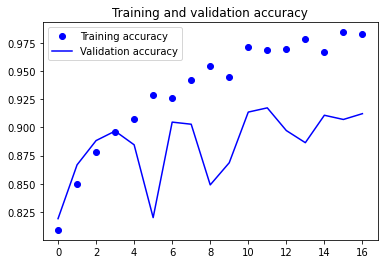

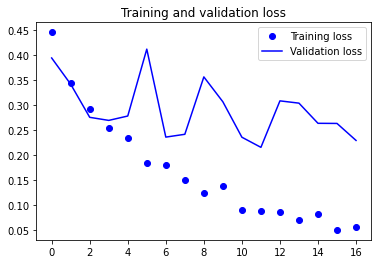

In [ ]:
run_model(vgg_ft_3_blocks, 'eperiment12_cut_ft_3_blocks', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8980    0.8477    0.8721       696
           1     0.9282    0.9534    0.9406      1437

    accuracy                         0.9189      2133
   macro avg     0.9131    0.9005    0.9064      2133
weighted avg     0.9183    0.9189    0.9183      2133



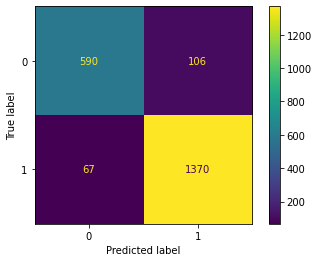

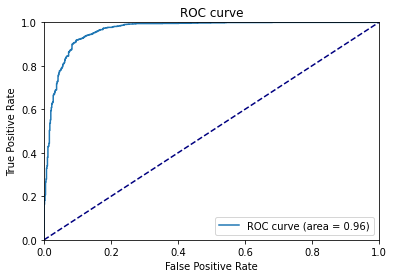

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment12_cut_ft_3_blocks.h5'))

#### Experiment 12bis: last three blocks RMSProp

In [ ]:
vgg_ft_3_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment8_cut_feature_extraction_dropout_rms.h5'))

for layer in vgg_ft_3_blocks.get_layer("sequential").layers:
    if layer.name in ('block1_conv2', 'block1_conv1'):
        layer.trainable = False
    else:
        layer.trainable = True

compile_model(vgg_ft_3_blocks, optimizer = "rms", learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_3_blocks.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.7921
Epoch 00001: val_loss improved from inf to 0.36794, saving model to /content/models/vgg16_cut_ft_3_blocks_rms.h5
200/200 [==============================] - 59s 290ms/step - loss: 0.4754 - accuracy: 0.7921 - val_loss: 0.3679 - val_accuracy: 0.8396
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4645 - accuracy: 0.7939
Epoch 00002: val_loss did not improve from 0.36794
200/200 [==============================] - 59s 292ms/step - loss: 0.4645 - accuracy: 0.7939 - val_loss: 0.3682 - val_accuracy: 0.8382
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4639 - accuracy: 0.7942
Epoch 00003: val_loss did not improve from 0.36794
200/200 [==============================] - 58s 291ms/step - loss: 0.4639 - accuracy: 0.7942 - val_loss: 0.3841 - val_accuracy: 0.8227
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.

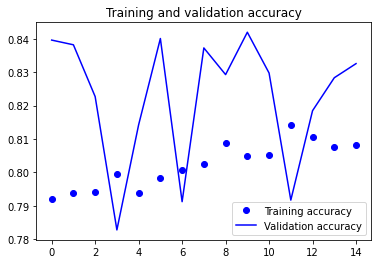

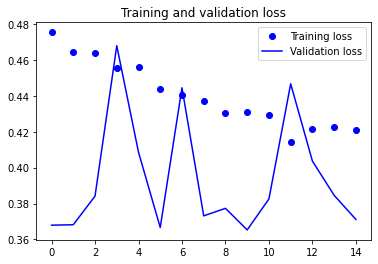

In [ ]:
run_model(vgg_ft_3_blocks, 'eperiment12bis_cut_ft_3_blocks', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8146    0.7198    0.7643       696
           1     0.8715    0.9207    0.8954      1437

    accuracy                         0.8551      2133
   macro avg     0.8431    0.8202    0.8299      2133
weighted avg     0.8530    0.8551    0.8526      2133



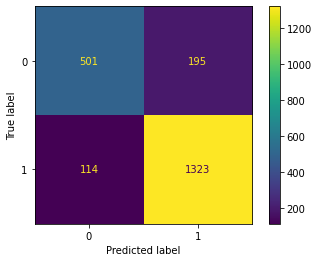

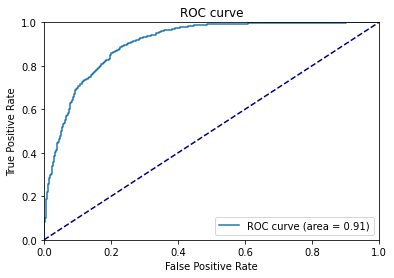

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment12bis_cut_ft_3_blocks.h5'))

#### Experiment 13: all blocks

In [ ]:
vgg_ft_all_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_all_blocks.get_layer("sequential_2").layers:
    if layer.name in (''):
        layer.trainable = False
    else:
        layer.trainable = True

compile_model(vgg_ft_all_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_all_blocks.get_layer('sequential_2').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.8099
Epoch 00001: val_loss improved from inf to 0.38701, saving model to /content/models/vgg16_cut_ft_all_blocks.h5
200/200 [==============================] - 172s 848ms/step - loss: 0.4206 - accuracy: 0.8099 - val_loss: 0.3870 - val_accuracy: 0.8269
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.8369
Epoch 00002: val_loss improved from 0.38701 to 0.31339, saving model to /content/models/vgg16_cut_ft_all_blocks.h5
200/200 [==============================] - 169s 842ms/step - loss: 0.3582 - accuracy: 0.8369 - val_loss: 0.3134 - val_accuracy: 0.8752
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.8859
Epoch 00003: val_loss improved from 0.31339 to 0.28661, saving model to /content/models/vgg16_cut_ft_all_blocks.h5
200/200 [==============================] - 169s 842ms/step - loss: 0.2793 - accuracy: 0.8859 - val

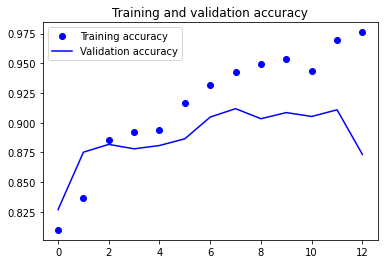

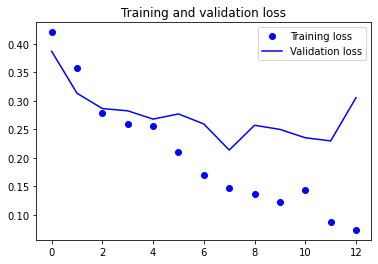

In [ ]:
run_model(vgg_ft_all_blocks, 'eperiment13_cut_ft_all_blocks', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8847    0.8491    0.8666       696
           1     0.9283    0.9464    0.9373      1437

    accuracy                         0.9147      2133
   macro avg     0.9065    0.8978    0.9019      2133
weighted avg     0.9141    0.9147    0.9142      2133



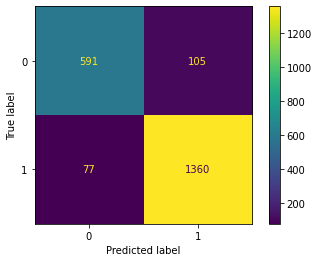

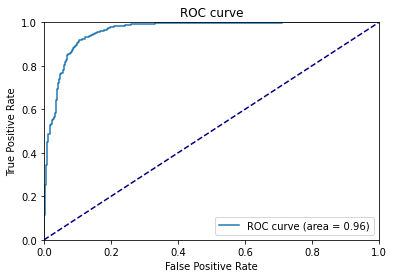

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment13_cut_ft_all_blocks.h5'))

## CLAHE
Taking the best network on the regular dataset, we evaluate whether or not adding a preprocessing step, i.e., applying CLAHE, improves performance. 

In [21]:
!unzip -q "/content/drive/My Drive/Baldi_Cioffo/SplittedDataset_CLAHE.zip" -d "/content"

In [22]:
DATASET_PATH = "/content/SplittedDataset_CLAHE"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

In [24]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


### Experiment 14: Remove Last Block + Fine Tuning of last Three Blocks + CLAHE

#### Feature Extraction

In [ ]:
model = Sequential()
for layer in conv_base.layers:
  if layer.name in ("block5_conv1"):
    break
  layer.trainable = False
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_cut_model_CLAHE = keras.Model(inputs, outputs)
compile_model(vgg_cut_model_CLAHE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 sequential_1 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 13.7404 - accuracy: 0.6703
Epoch 00001: val_loss improved from inf to 3.26155, saving model to /content/models/vgg16_cut_model_1fc_dropout_CLAHE.h5
200/200 [==============================] - 74s 366ms/step - loss: 13.7404 - accuracy: 0.6703 - val_loss: 3.2615 - val_accuracy: 0.7917
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 8.0592 - accuracy: 0.7043
Epoch 00002: val_loss improved from 3.26155 to 2.93487, saving model to /content/models/vgg16_cut_model_1fc_dropout_CLAHE.h5
200/200 [==============================] - 59s 294ms/step - loss: 8.0592 - accuracy: 0.7043 - val_loss: 2.9349 - val_accuracy: 0.7866
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 4.7839 - accuracy: 0.7209
Epoch 00003: val_loss improved from 2.93487 to 1.86551, saving model to /content/models/vgg16_cut_model_1fc_dropout_CLAHE.h5
200/200 [==============================] - 59s 293ms/step - loss: 4.

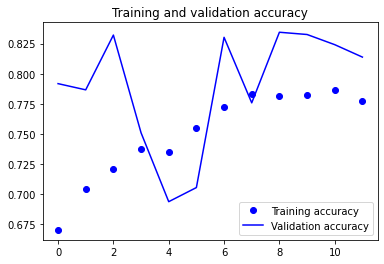

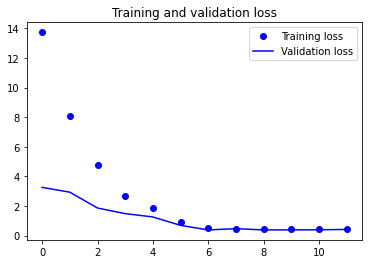

In [ ]:
run_model(vgg_cut_model_CLAHE, 'experiment14_1_cut_feature_extraction_CLAHE', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.7628    0.7299    0.7460       696
           1     0.8718    0.8900    0.8809      1437

    accuracy                         0.8378      2133
   macro avg     0.8173    0.8100    0.8134      2133
weighted avg     0.8363    0.8378    0.8368      2133



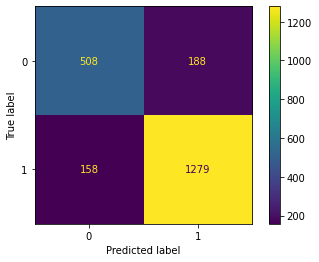

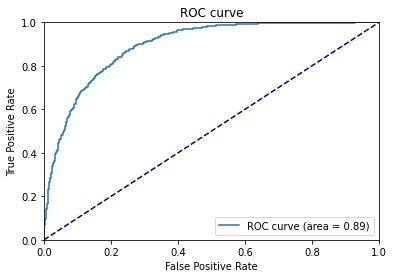

In [25]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment14_1_cut_feature_extraction_CLAHE.h5'))

#### Fine Tuning

In [ ]:
vgg_ft_3_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment14_1_cut_feature_extraction_CLAHE.h5'))

for layer in vgg_ft_3_blocks.get_layer("sequential_1").layers:
    if layer.name in ('block1_conv2', 'block1_conv1'):
        layer.trainable = False
    else:
        layer.trainable = True

compile_model(vgg_ft_3_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_3_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 sequential_1 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.7916
Epoch 00001: val_loss improved from inf to 0.35305, saving model to /content/models/vgg16_cut_ft_3_blocks_CLAHE.h5
200/200 [==============================] - 131s 649ms/step - loss: 0.4580 - accuracy: 0.7916 - val_loss: 0.3531 - val_accuracy: 0.8480
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8229
Epoch 00002: val_loss improved from 0.35305 to 0.34368, saving model to /content/models/vgg16_cut_ft_3_blocks_CLAHE.h5
200/200 [==============================] - 128s 640ms/step - loss: 0.3918 - accuracy: 0.8229 - val_loss: 0.3437 - val_accuracy: 0.8574
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8554
Epoch 00003: val_loss improved from 0.34368 to 0.28609, saving model to /content/models/vgg16_cut_ft_3_blocks_CLAHE.h5
200/200 [==============================] - 128s 639ms/step - loss: 0.3313 - accuracy: 

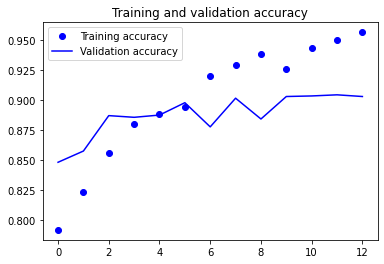

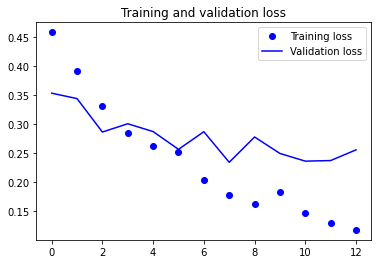

In [ ]:
run_model(vgg_ft_3_blocks, 'experiment14_2_cut_finetuning_3_blocks_CLAHE', epochs = 100, patience=5, monitor='val_loss')

Classification report: 
              precision    recall  f1-score   support

           0     0.8810    0.8405    0.8603       696
           1     0.9244    0.9450    0.9346      1437

    accuracy                         0.9109      2133
   macro avg     0.9027    0.8928    0.8975      2133
weighted avg     0.9103    0.9109    0.9104      2133



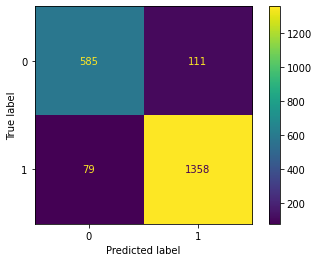

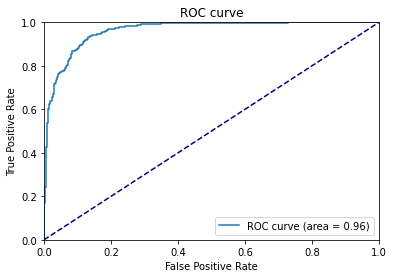

In [26]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment14_2_cut_finetuning_3_blocks_CLAHE.h5'))

As shown above, no improvement can be seen with the application of CLAHE. Perhaps all experiments should be repeated from scratch to find the best combination for the images that have been transformed in this way. 